In [1]:
import os
import pandas as pd
import nltk
import logging
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
from gensim.utils import simple_preprocess
from collections import Counter
from functools import lru_cache
import matplotlib.pyplot as plt

In [4]:
# -------------------------------
# 0. Setup & Anti-Hallucination
# -------------------------------

logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

# Download NLTK resources quietly
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

comments_file = "comments.csv"
stopword_file = "tagalog_stopwords.txt"

if not os.path.exists(comments_file):
    raise FileNotFoundError(f"❌ Missing input file: {comments_file}")

if not os.path.exists(stopword_file):
    raise FileNotFoundError(f"❌ Missing stopword file: {stopword_file}")

In [5]:
# -------------------------------
# 1. Data Collection
# -------------------------------
df = pd.read_csv(comments_file)

if "Comments" not in df.columns:
    raise ValueError("❌ CSV file must have a 'Comments' column.")

if df.empty:
    raise ValueError("❌ CSV file is empty. Cannot run topic modeling.")

print("✅ Dataset loaded successfully!")
print("Dataset shape:", df.shape)
print("First 5 rows:\n", df.head())

✅ Dataset loaded successfully!
Dataset shape: (978, 1)
First 5 rows:
                                             Comments
0  bat walang gumagalaw Kay Romualdez eh siya nga...
1                               kunyari hindi alam..
2  question before mag release nang full payment ...
3              di ako naniniwala na di nila alam yan
4          Sana kampi ka sa kabutihan Vince Dizon 🙏🙏


In [6]:
# -------------------------------
# 2. Stopword Preparation
# -------------------------------
with open(stopword_file, "r", encoding="utf-8") as f:
    tagalog_stopwords = set([line.strip() for line in f if line.strip()])

# Combine English + Tagalog stopwords
all_stopwords = set(stopwords.words("english")).union(tagalog_stopwords)
print(f"✅ Loaded {len(all_stopwords)} total stopwords.")

✅ Loaded 488 total stopwords.


In [7]:
# -------------------------------
# 3. Preprocessing
# -------------------------------
lemmatizer = WordNetLemmatizer()

from functools import lru_cache
@lru_cache(maxsize=100000)
def lemmatize_word(word):
    return lemmatizer.lemmatize(word)

def preprocess(text):
    """
    Tokenize, clean, lemmatize, and remove stopwords.
    Drops 1-2 character tokens like 'm', 'u', 'ma', 'ta'.
    """
    tokens = simple_preprocess(str(text), deacc=True)
    clean_tokens = []
    for t in tokens:
        t = t.strip()
        if t and t.isalpha():  # keep only alphabetic tokens
            if t not in all_stopwords:  # check stopword membership
                if len(t) > 2:  # drop short words (1-2 letters)
                    clean_tokens.append(lemmatize_word(t))
    return clean_tokens

texts = df["Comments"].dropna().astype(str).tolist()
processed_texts = [preprocess(doc) for doc in texts]

# -------------------------------
# EXTRA FILTER: Remove specific 2-letter words manually
# -------------------------------
two_letter_exceptions = {"ma", "ta", "pa", "na", "sa", "ng", "go", "as", "dd", "po", "do", "ab"}  # add more if needed
processed_texts = [
    [t for t in doc if t not in two_letter_exceptions]
    for doc in processed_texts
]

# ✅ Debugging: check if problematic tokens still exist
all_tokens_flat = [t for doc in processed_texts for t in doc]
problematic_tokens = {t for t in all_tokens_flat if len(t) <= 2}
if problematic_tokens:
    print(f"⚠️ WARNING: Some short tokens still remain: {problematic_tokens}")
else:
    print("✅ All 1-2 letter tokens removed successfully.")

if not any(processed_texts):
    raise ValueError("❌ All tokens were removed after preprocessing. Check stopword list.")

print("\nSample preprocessed text:", processed_texts[0][:20])

✅ All 1-2 letter tokens removed successfully.

Sample preprocessed text: ['gumagalaw', 'romualdez', 'pinaka', 'suspicious']


In [8]:
# -------------------------------
# 4. Dictionary & Corpus
# -------------------------------
dictionary = Dictionary(processed_texts)
dictionary.filter_extremes(no_below=2, no_above=0.7)

if len(dictionary) == 0:
    raise ValueError("❌ Dictionary is empty after filtering. Try lowering 'no_above' or 'no_below'.")

corpus = [dictionary.doc2bow(text) for text in processed_texts]

2025-09-20 21:26:07,883 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-09-20 21:26:07,894 : INFO : built Dictionary<3949 unique tokens: ['gumagalaw', 'pinaka', 'romualdez', 'suspicious', 'alam']...> from 978 documents (total 8292 corpus positions)
2025-09-20 21:26:07,895 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<3949 unique tokens: ['gumagalaw', 'pinaka', 'romualdez', 'suspicious', 'alam']...> from 978 documents (total 8292 corpus positions)", 'datetime': '2025-09-20T21:26:07.895524', 'gensim': '4.3.3', 'python': '3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'created'}
2025-09-20 21:26:07,899 : INFO : discarding 2710 tokens: [('gumagalaw', 1), ('suspicious', 1), ('kunyari', 1), ('release', 1), ('kabutihan', 1), ('kampi', 1), ('anyone', 1), ('higher', 1), ('imposible', 1), ('kalakaran', 1)]...
2025-09-20 21:26:07,900 : INFO : keeping 1239 tokens which were in 

In [9]:
# -------------------------------
# 5. Compute Optimal Number of Topics
# -------------------------------
def compute_coherence(dictionary, corpus, texts, limit, start=3, step=1):
    coherence_values = []
    model_list = []
    num_cores = max(1, multiprocessing.cpu_count() - 1)
    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            iterations=400,
            random_state=42,
            alpha="symmetric",  # avoid auto-tuning (not supported in LdaMulticore)
            eta=None,
            chunksize=2000,
            eval_every=None,
            workers=num_cores
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence(dictionary, corpus, processed_texts, limit=11, start=3, step=1)

# ✅ Pick best number of topics based on coherence score
x = range(3, 11)
best_num = x[coherence_values.index(max(coherence_values))]
print(f"✅ Best number of topics: {best_num}")

2025-09-20 21:26:10,834 : INFO : using symmetric alpha at 0.3333333333333333
2025-09-20 21:26:10,836 : INFO : using symmetric eta at 0.3333333333333333
2025-09-20 21:26:10,837 : INFO : using serial LDA version on this node
2025-09-20 21:26:10,845 : INFO : running online LDA training, 3 topics, 10 passes over the supplied corpus of 978 documents, updating every 22000 documents, evaluating every ~0 documents, iterating 400x with a convergence threshold of 0.001000
2025-09-20 21:26:10,850 : INFO : training LDA model using 11 processes
2025-09-20 21:26:12,143 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #978/978, outstanding queue size 1
2025-09-20 21:26:13,638 : INFO : topic #0 (0.333): 0.024*"project" + 0.014*"flood" + 0.013*"control" + 0.010*"corruption" + 0.010*"pera" + 0.009*"bansa" + 0.009*"corrupt" + 0.008*"dpwh" + 0.008*"bayan" + 0.007*"magnanakaw"
2025-09-20 21:26:13,640 : INFO : topic #1 (0.333): 0.009*"corruption" + 0.008*"tapos" + 0.008*"discaya" + 0.008*"pr

✅ Best number of topics: 10


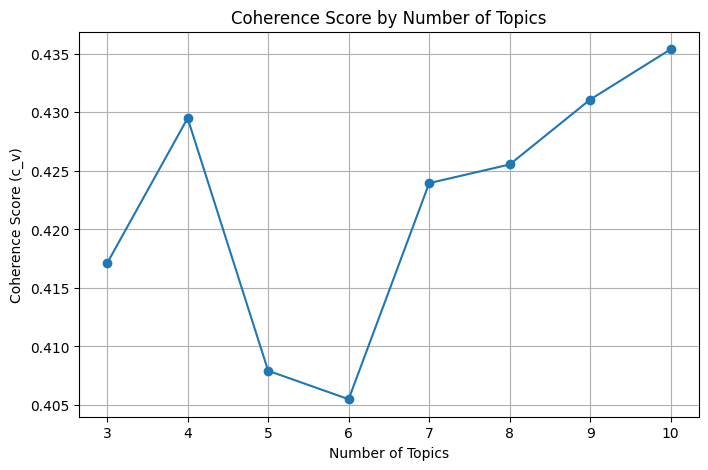

In [10]:
# -------------------------------
# 5b. Visualize Coherence Score
# -------------------------------
import matplotlib.pyplot as plt

x = list(range(3, 11))  # topic numbers we tested
plt.figure(figsize=(8, 5))
plt.plot(x, coherence_values, marker="o")
plt.title("Coherence Score by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.xticks(x)
plt.show()

In [11]:
# -------------------------------
# 6. Train Final Model
# -------------------------------
final_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num,
    passes=10,
    iterations=400,
    random_state=42,
    alpha="symmetric",
    eta=None,
    chunksize=2000,
    eval_every=None,
    workers=max(1, multiprocessing.cpu_count() - 1)
)

2025-09-20 21:28:40,331 : INFO : using symmetric alpha at 0.1
2025-09-20 21:28:40,333 : INFO : using symmetric eta at 0.1
2025-09-20 21:28:40,334 : INFO : using serial LDA version on this node
2025-09-20 21:28:40,337 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 978 documents, updating every 22000 documents, evaluating every ~0 documents, iterating 400x with a convergence threshold of 0.001000
2025-09-20 21:28:40,338 : INFO : training LDA model using 11 processes
2025-09-20 21:28:52,691 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #978/978, outstanding queue size 1
2025-09-20 21:28:52,916 : INFO : topic #7 (0.100): 0.012*"corruption" + 0.010*"gobyerno" + 0.010*"galit" + 0.008*"bayan" + 0.008*"project" + 0.008*"pera" + 0.007*"buhay" + 0.007*"budget" + 0.007*"money" + 0.007*"ghost"
2025-09-20 21:28:52,917 : INFO : topic #3 (0.100): 0.024*"project" + 0.014*"magnanakaw" + 0.013*"tapos" + 0.012*"corruption" + 0.010*"mayor" + 0.009

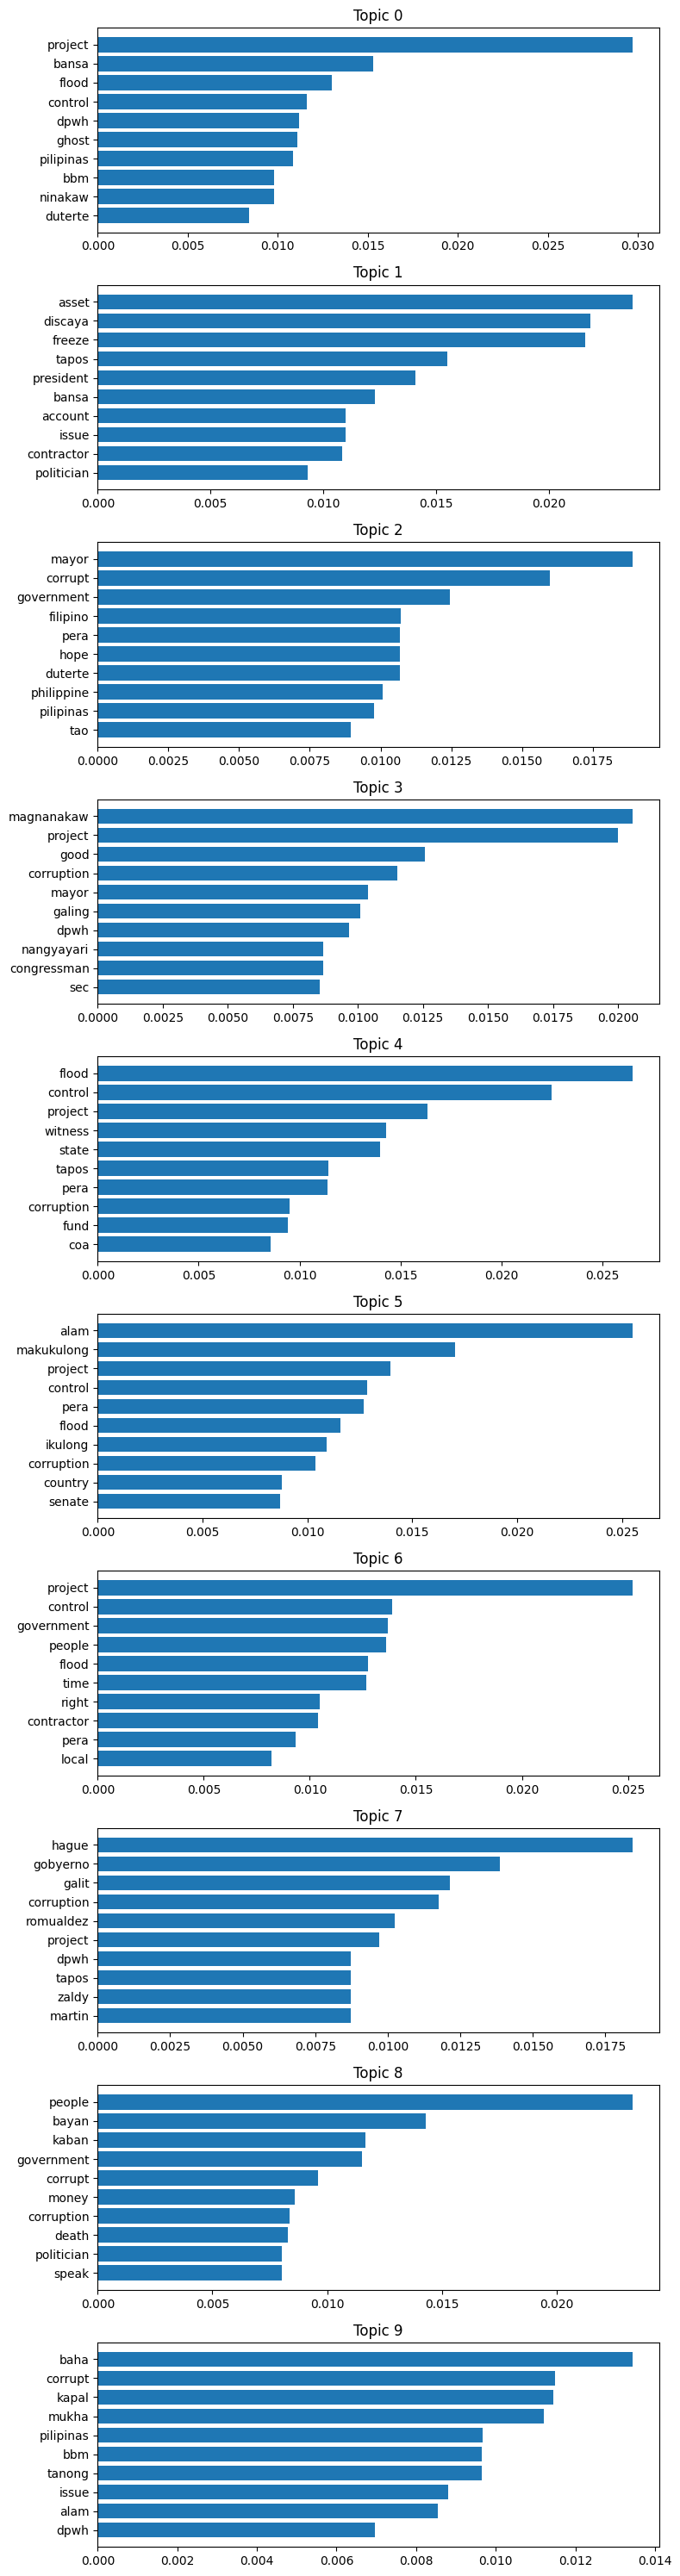

In [12]:
# -------------------------------
# 7. Display & Save Topics
# -------------------------------
topics_data = []
topics = final_model.show_topics(num_topics=best_num, num_words=10, formatted=False)

fig, axes = plt.subplots(nrows=len(topics), ncols=1, figsize=(8, len(topics) * 3))

if len(topics) == 1:
    axes = [axes]  # make iterable if only one topic

for (topic_idx, topic), ax in zip(topics, axes):
    words, weights = zip(*topic)
    topics_data.append({"Topic": topic_idx, "Words": ", ".join(words)})
    ax.barh(words, weights)
    ax.invert_yaxis()
    ax.set_title(f"Topic {topic_idx}")

plt.tight_layout()
plt.show()

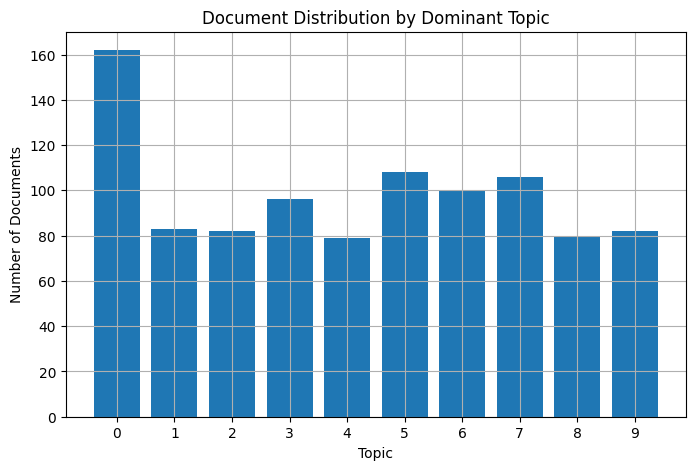

In [13]:
# -------------------------------
# 8. Topic Distribution Across Documents
# -------------------------------
doc_topics = []
for doc in corpus:
    topic_probs = final_model.get_document_topics(doc)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0] if topic_probs else -1
    doc_topics.append(dominant_topic)

plt.figure(figsize=(8, 5))
plt.hist([t for t in doc_topics if t >= 0], bins=range(best_num + 1), align="left", rwidth=0.8)
plt.xticks(range(best_num))
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Document Distribution by Dominant Topic")
plt.grid()
plt.show()

In [14]:
# -------------------------------
# 9. Summarize Topics into Text
# -------------------------------

def summarize_topics(model, num_words=10):
    """
    Summarize all topics into a single text string.
    Each topic is listed with its top words.
    """
    if model is None:
        print("⚠️ No model provided. Cannot summarize topics.")
        summarized_text = ""
    else:
        topics = model.show_topics(num_topics=model.num_topics, num_words=num_words, formatted=False)
        summarized_text = ""
        for idx, topic in topics:
            words = [w for w, _ in topic]
            summarized_text += f"Topic {idx}: {', '.join(words)}\n"

    print("\n--- Topic Summary ---\n")
    print(summarized_text)
    return summarized_text

# Call the function to display the summary
topic_summary_text = summarize_topics(final_model)



--- Topic Summary ---

Topic 0: project, bansa, flood, control, dpwh, ghost, pilipinas, bbm, ninakaw, duterte
Topic 1: asset, discaya, freeze, tapos, president, bansa, account, issue, contractor, politician
Topic 2: mayor, corrupt, government, filipino, pera, hope, duterte, philippine, pilipinas, tao
Topic 3: magnanakaw, project, good, corruption, mayor, galing, dpwh, nangyayari, congressman, sec
Topic 4: flood, control, project, witness, state, tapos, pera, corruption, fund, coa
Topic 5: alam, makukulong, project, control, pera, flood, ikulong, corruption, country, senate
Topic 6: project, control, government, people, flood, time, right, contractor, pera, local
Topic 7: hague, gobyerno, galit, corruption, romualdez, project, dpwh, tapos, zaldy, martin
Topic 8: people, bayan, kaban, government, corrupt, money, corruption, death, politician, speak
Topic 9: baha, corrupt, kapal, mukha, pilipinas, bbm, tanong, issue, alam, dpwh



In [147]:
# -------------------------------
# 10. Save & Load Model
# -------------------------------

model_path = "final_lda_model.gensim"
dictionary_path = "lda_dictionary.gensim"

final_model.save(model_path)
dictionary.save(dictionary_path)
print("✅ Model & dictionary saved!")

✅ Model & dictionary saved!


In [15]:
# -------------------------------
# 11. Model Performance Evaluation
# -------------------------------

# Perplexity (lower is better)
perplexity = final_model.log_perplexity(corpus)
print(f"📉 Model Perplexity: {perplexity:.4f}")

# Coherence Score (c_v)
coherence_model_lda = CoherenceModel(model=final_model, texts=processed_texts,
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"📈 Model Coherence Score (c_v): {coherence_lda:.4f}")

2025-09-20 21:29:56,674 : INFO : -7.626 per-word bound, 197.5 perplexity estimate based on a held-out corpus of 978 documents with 5474 words
2025-09-20 21:29:56,677 : INFO : using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows


📉 Model Perplexity: -7.6257


2025-09-20 21:29:59,665 : INFO : 11 accumulators retrieved from output queue
2025-09-20 21:29:59,673 : INFO : accumulated word occurrence stats for 986 virtual documents


📈 Model Coherence Score (c_v): 0.4354


2025-09-20 21:30:09,343 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-20 21:30:09,345 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



📊 Top 10 Topics by Assigned Documents:
   Topic  Document Count
0      0             162
1      5             108
2      7             106
3      6             100
4      3              96
5      1              83
6      9              82
7      2              82
8      8              80
9      4              79


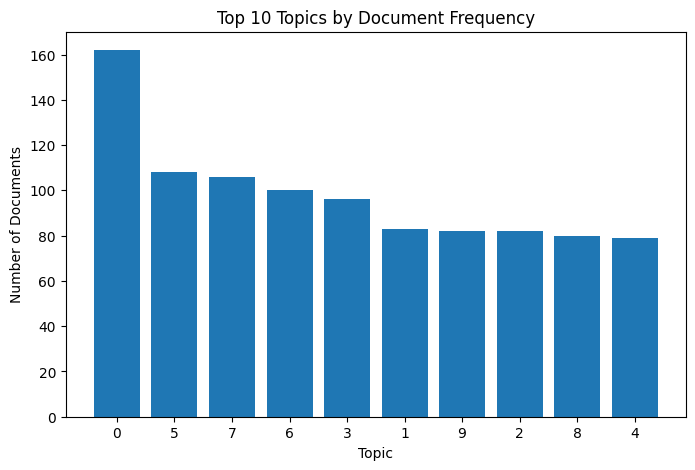

In [ ]:
# -------------------------------
# 12. Top Topics by Document Frequency
# -------------------------------
topic_counts = Counter(doc_topics)
top_topics = topic_counts.most_common(10)

# Convert to DataFrame for clearer view
df_top_topics = pd.DataFrame(top_topics, columns=["Topic", "Document Count"])
print("\n📊 Top 10 Topics by Assigned Documents:")
print(df_top_topics)

# Visualize as bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_top_topics["Topic"].astype(str), df_top_topics["Document Count"])
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Top 10 Topics by Document Frequency")
plt.show()